In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

print(tf.__version__)


2.16.1


## Prepare the Dataset

In [2]:
train_dataset = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv', header=None)
val_dataset = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv', header=None)

print(train_dataset.info())
print(val_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       74682 non-null  int64 
 1   1       74682 non-null  object
 2   2       74682 non-null  object
 3   3       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1000 non-null   int64 
 1   1       1000 non-null   object
 2   2       1000 non-null   object
 3   3       1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB
None


In [3]:
def preprocess(dataset):
    #train_dataset.duplicated().sum()
    dataset.drop_duplicates(inplace=True)
    
    #for col in train_dataset.columns:
        #print(f"{col}: {len(train_dataset[col].unique())}")
    dataset.dropna(inplace=True)
    
    return dataset

In [4]:
train_dataset = preprocess(train_dataset)
val_dataset = preprocess(val_dataset)

X_train = train_dataset[3]
y_train = train_dataset[2]

X_val = val_dataset[3]
y_val = val_dataset[2]

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

print(le.classes_)

['Irrelevant' 'Negative' 'Neutral' 'Positive']


## Tokenize the Dataset

In [6]:
vocab_size = 2000
embedding_dim = 16
max_length = 80
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
# print(word_index)

train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(train_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(X_val)
X_val_padded = pad_sequences(val_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

## Review a Sequence

In [7]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(X_train_padded[1]))
print(X_train[1])

i am coming to the <OOV> and i will kill you all ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
I am coming to the borders and I will kill you all,


## Train Basic Sentiment Model

In [8]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
# Build a basic sentiment network
# Note the embedding layer is first, 
# and the output is only 1 node as it is either 0 or 1 (negative or positive)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(max_length,)),
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss=SparseCategoricalCrossentropy(),optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 80, 16)         │        32,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        20,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,636 (209.52 KB)

 Trainable params: 53,636 (209.52 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
num_epochs = 20
history = model.fit(X_train_padded, y_train, epochs=num_epochs, validation_data=(X_val_padded, y_val))

Epoch 1/20
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.4513 - loss: 1.1950 - val_accuracy: 0.7240 - val_loss: 0.7400
Epoch 2/20
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6956 - loss: 0.7757 - val_accuracy: 0.8380 - val_loss: 0.4659
Epoch 3/20
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7797 - loss: 0.5853 - val_accuracy: 0.8800 - val_loss: 0.3670
Epoch 4/20
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8149 - loss: 0.4937 - val_accuracy: 0.8960 - val_loss: 0.3167
Epoch 5/20
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8388 - loss: 0.4347 - val_accuracy: 0.8930 - val_loss: 0.3244
Epoch 6/20
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8541 - loss: 0.3937 - val_accuracy: 0.9040 - val_loss: 0.3020
Epoch 7/20
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8641 - loss: 0.3636 - val_accuracy: 0.9110 - val_loss: 0.3004
Epoch 8/20
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8734 - loss: 0.3446 - 

## Visualize accuracy and loss

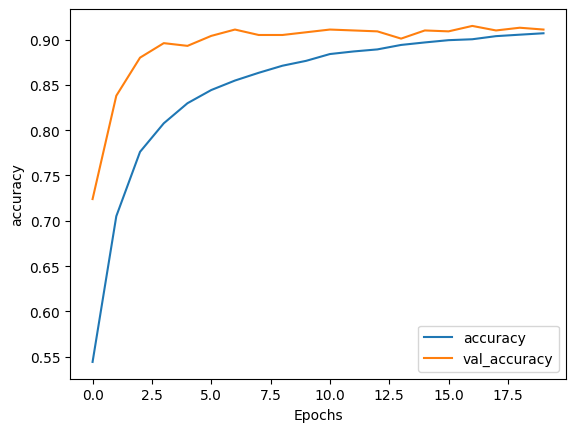

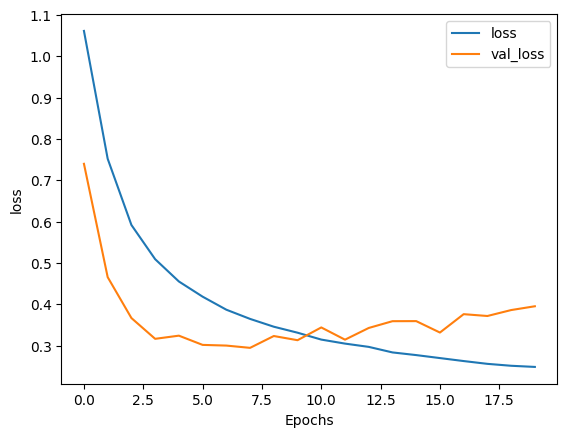

In [10]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Save the model

In [11]:
model.export('models/sentiment_analysis_model')

Saved artifact at 'models/sentiment_analysis_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 80), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140381262762000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381262765696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381262767280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381262764992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381262766224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381262770800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381262767808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381262772736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381262771504: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [18]:
#In .keras format
from tensorflow.keras.models import save_model
model.save("model.keras")

## Save tokenizer

In [13]:
import pickle

# Save the tokenizer
with open('/kaggle/working/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


## Files for Visualizations

In [14]:
# # First get the weights of the embedding layer
# e = model.layers[0]
# weights = e.get_weights()[0]
# print(weights.shape) # shape: (vocab_size, embedding_dim)

In [15]:
# import io

# # Write out the embedding vectors and metadata
# out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
# out_m = io.open('meta.tsv', 'w', encoding='utf-8')
# for word_num in range(1, vocab_size):
#   word = reverse_word_index[word_num]
#   embeddings = weights[word_num]
#   out_m.write(word + "\n")
#   out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
# out_v.close()
# out_m.close()

In [16]:
# # Download the files
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download('vecs.tsv')
#   files.download('meta.tsv')

# Inference

In [17]:
# Use the model to predict a review   
fake_reviews = ['I love this phone', 'I hate spaghetti', 
                'Everything was cold',
                'Everything was hot exactly as I wanted', 
                'Everything was green', 
                'the host seated us immediately',
                'they gave us free chocolate cake', 
                'not sure about the wilted flowers on the table',
                'only works when I stand on tippy toes', 
                'does not work when I stand on my head']

print(fake_reviews) 

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(fake_reviews)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           

print('\nHOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!\n')              

classes = model.predict(fakes_padded)

# The closer the class is to 1, the more positive the review is deemed to be
for x in range(len(fake_reviews)):
  print(fake_reviews[x])
  print(classes[x])
  print('\n')

# Try adding reviews of your own
# Add some negative words (such as "not") to the good reviews and see what happens
# For example:
# they gave us free chocolate cake and did not charge us

['I love this phone', 'I hate spaghetti', 'Everything was cold', 'Everything was hot exactly as I wanted', 'Everything was green', 'the host seated us immediately', 'they gave us free chocolate cake', 'not sure about the wilted flowers on the table', 'only works when I stand on tippy toes', 'does not work when I stand on my head']

HOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
I love this phone
[0.17733279 0.14688939 0.1527776  0.5230002 ]


I hate spaghetti
[0.02206873 0.89405453 0.03839958 0.04547716]


Everything was cold
[0.11403821 0.51834637 0.18750711 0.18010835]


Everything was hot exactly as I wanted
[0.08640747 0.81552434 0.05194061 0.04612765]


Everything was green
[0.47048926 0.13898881 0.31630024 0.07422168]


the host seated us immediately
[0.9679714  0.00634688 0.01066629 0.01501536]


they gave us free chocolate cake
[0.6780409  0.04541415 0.10907023 0.16747469]


not sure about the wilted flowers on 